Dataset from :-

http://gpcv.whu.edu.cn/data/Bijie_pages.html

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, cv2
from PIL import Image
%matplotlib inline

EPOCHS = 100
BATCH = 16

In [8]:
shp_dict = {}
for i in os.listdir("landslide/image/"):
    i = cv2.imread("landslide/image/"+i)
    if i.shape in shp_dict:
        shp_dict[i.shape]+=1
    else:
        shp_dict[i.shape]=1

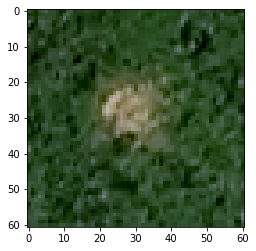

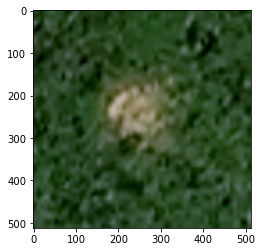

In [14]:
img = Image.open("landslide/image/df004.png")
plt.imshow(img)
plt.show()
img = np.array(img.resize((512, 512)))
plt.imshow(img)
plt.show()

In [20]:
classes = ["landslide", "non-landslide"]

train_df = pd.DataFrame({"images":[],"labels":[]})
for cls in classes:
    images = os.listdir(cls + "/image/")
    for img in range(len(images)):
        images[img] = cls + "/image/" + images[img]
    temp = pd.DataFrame({"images":images,"labels":[cls]*(len(images))})
    train_df = pd.concat([train_df, temp])

classes_to_int = {cls:i for i,cls in enumerate(classes)}
train_df['labels'] = train_df['labels'].replace(classes_to_int)    

train_df.shape

(2773, 2)

In [21]:
train_df.sample(frac=1).reset_index(drop=True).head()

,images,labels
0,non-landslide/image/fyb503.png,1
1,non-landslide/image/dnygf10098.png,1
2,non-landslide/image/dnypl05019.png,1
3,landslide/image/hz021.png,0
4,landslide/image/qxg092.png,0


In [ ]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, dataset, labels, transform=None, target_transform=None):
        self.dataset = dataset
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img = Image.open(self.dataset[index])
        img = np.array(img.resize((512, 512)))
        label = self.labels[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            label = self.target_transform
        return img, label

train_set = DataSet(train_df['images'].values, train_df['labels'].values)
train_dl = torch.utils.data.DataLoader(train_set, batch_size = BATCH, shuffle = True)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, pretrained_network = None, out_shape = out_size):
        super().__init__()
        self.masked_output = pretrained_network
        self.conv2d1 = torch.nn.Conv2d(7, 4, kernel_size=3, stride=2)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2d2 = torch.nn.Conv2d(4, 8, kernel_size=3, stride=2)
        self.dropout2 = nn.Dropout(0.2)
        self.conv2d3 = torch.nn.Conv2d(8, 4, kernel_size=3, stride=2)
        self.dropout3 = nn.Dropout(0.2)
        self.conv2d4 = torch.nn.Conv2d(4, 2, kernel_size=3, stride=2)
        self.dropout4 = nn.Dropout(0.2)
        self.dense1 = torch.nn.Linear(1922, 512)
        self.dense2 = torch.nn.Linear(512, 1)

    def forward(self, x):
        x = self.masked_output(x)
        
        x = self.conv2d1(x)
        x = nn.ReLU()(x)
        x = self.dropout1(x)
        
        x = self.conv2d2(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        
        x = self.conv2d3(x)
        x = nn.ReLU()(x)
        x = self.dropout3(x)
        
        x = self.conv2d4(x)
        x = nn.ReLU()(x)
        x = self.dropout4(x)
        
        x = torch.nn.Flatten()(x)
        x = self.dense1(x)
        x = torch.nn.ReLU()(x)

        x = self.dense2(x)
        x = torch.nn.Sigmoid()(x)
        return x

    def trainig_step(self, batch):
        images, labels = batch
        preds = self(images)
        loss = torch.nn.functional.binary_cross_entropy(preds, labels)
        return loss
    
obj = Model()
obj.to(torch.device('cuda'))
summary(obj, (7, 512, 512))

In [ ]:
opt = torch.optim.SGD(obj.parameters(), lr = 0.001)
for i in range(EPOCHS):
    for batch in train_dl:
        loss = obj.trainig_step(batch)
        loss.backward()
        opt.step()
        opt.zero_grad() 
    print(loss)
#     losses=[]
#     for batch in val_dl:
#         losses.append(obj.validation_step(batch).item())
#     print("val loss: ",np.mean(losses))
    # break